In [1]:
using Optim, LsqFit
using Plots, StatsPlots, LaTeXStrings
using DelimitedFiles
using Statistics
using Turing
using DataFrames
using BenchmarkTools

In [2]:
pyplot(grid=:off)

Plots.PyPlotBackend()

In [3]:
ENV["COLUMNS"]=120
figdir = "figures/";

# Viral load data fitting

## Confidence intervals and goodness of fit

## Data set

10 mice with 13 data points each

In [4]:
RAWDATA = readdlm("../../data/To2020/Figure_2_Viral_Load.csv", ',', Any, '\n', header=true)[1]
COLS = readdlm("../../data/To2020/Figure_2_Viral_Load.csv", ',', Any, '\n', header=true)[2]
DataFrame(RAWDATA)

30×24 DataFrame
 Row │ x1   x2       x3       x4       x5       x6       x7       x8       x9       x10      x11      x12      x13     ⋯
     │ Any  Any      Any      Any      Any      Any      Any      Any      Any      Any      Any      Any      Any     ⋯
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 0                                                                                                               ⋯
   2 │ 1    5.21924
   3 │ 2                                                                   8.42034                    3.76403
   4 │ 3    4.77062                                                        6.05675
   5 │ 4                      8.63656                                      6.21165  4.85564  6.04999                   ⋯
   6 │ 5             7.38193                    6.6963                     7.11621  6.68878  1
   7 │ 6    1        7.35384                                      7.04338  1
   8 │ 7    5.29376                                                        4.7673
   9 │ 8    1                 7.85297  8.4431                     6.96152  5.14451                                     ⋯
  10 │ 9    1        6.34922           4.51444  5.57185                    5.02366           4.86356           6.77699
  11 │ 10   4.32197                    4.2957            5.17365  3.93571  3.40161
  ⋮  │  ⋮      ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮    ⋱
  21 │ 20   3.28592  1                 8.93792                             2.94448           4.3476
  22 │ 21   1                          1                                   1                 4.6175                    ⋯
  23 │ 22   1                          1                                   2.98588           4.47851
  24 │ 23   1        1                 4.79574                             1                 3.90827
  25 │ 24   1        1                 4.7673
  26 │ 25   1                          1                                                                               ⋯
  27 │ 26   1        1                 1
  28 │ 27   1                          1
  29 │ 28            1                 1
  30 │ 29                              1                                                                               ⋯
                                                                                           11 columns and 9 rows omitted

In [5]:
data = copy(RAWDATA)
data[data .== ""] .= missing
tdata = Float64.(data[:, 1]);
data[[7,9, 10, 12, 13, 14, 16, 17, 19], 2] .= missing
data[[22, 23], 5] .= missing
data[[7, 22], 9] .= missing
data[[6, ], 11] .= missing
data[[25, 26], 16] .= missing
data[[17, ], 17] .= missing
data[[7, ], 19] .= missing
data[[12, ], 20] .= missing
data[[9, 10], 21] .= missing
data[[1, 30], 2:end] .= 1.;

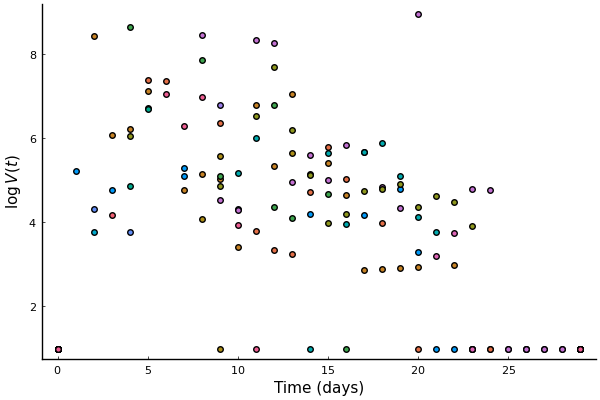

In [6]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[:, i], seriestype=:scatter) for i in 2:size(data, 2)]
plt

## Standard virus load function

The virus load function with three main phases given by

$$V(t; p)=v_1(t; a_1, a_2, V_{\max})v_2(t; a_2, \alpha)v_3(t; b_1, b_2, V_{\min}),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t; a_1, a_2, V_{\max}) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t; a_2, \alpha) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t; b_1, b_2, V_{\min}) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function, and $p=(a_1, a_2, b_1, b_2, \alpha, V_{\min}, V_{\max})^t$ is the vector of parameters. There are non-nengativity $a_1, a_2, b_1, b_2, \alpha, V_{\min}, V_{\max} >0$, and ordering $0<a_1<a_2<b_1<b_2$ conditions.

In [7]:
# H(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
H(x) = 0.5*(tanh(1e3*x) + 1.)
function v₁(t, a₁, a₂, logVmax)
    1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/abs(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/abs(a₂ - a₁)))/2
end
function v₂(t, a₂, α) 
    1. - H(t - a₂) + H(t - a₂)*exp(-α*(t - a₂))
end
function v₃(t, b₁, b₂, logVmin)
    1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/abs(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/abs(b₂ - b₁)))/2
end
function LogVirusLoad(t, a₁, a₂, b₁, b₂, α, logVmax)
    θ = minimum(vvdata)
    logVmin = -6.0
    logV = log10(v₁(t, a₁, a₂, logVmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, logVmin))
    max(logV, θ)
end
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmax"];

In [8]:
function assert_params(a₁, a₂, b₁, b₂, α, logVmax)
    all([a₁ < a₂, a₂ < b₁, b₁ < b₂, a₁ > 0, a₂ > 0, b₁ > 0, b₂ > 0, α > 0, logVmax > 0])
end

assert_params (generic function with 1 method)

In [9]:
k = 2
ttdata = repeat(tdata, inner=1)
tend = ttdata[end]
vvdata = reshape(data[:, k], 1, :)[:]
idx = .!ismissing.(vvdata)
ttdata = ttdata[idx]
vvdata = vvdata[idx]
cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)

cost (generic function with 1 method)

## Optimization

As see

Estimate $\hat p$

In [10]:
function fitVLF()
    bestfit = nothing 
    for i = 1:10
        par0 = vcat(sort(ttdata[end]*rand(4)), [0.80, maximum(vvdata)])
        lb   = vcat(0.0, (par0[1:3] + par0[2:4])/2, [1e-8, par0[6] - 4])
        ub   = vcat((par0[1:3] + par0[2:4])/2, [tend, 10.0, par0[6] + 4])
        fit1 = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^6))
        if assert_params(fit1.minimizer...)
            if bestfit == nothing
                bestfit = fit1
            else
                if fit1.minimum < bestfit.minimum 
                    bestfit = fit1
                end
            end
        end
    end
    return bestfit
end

fitVLF (generic function with 1 method)

In [34]:
fit1 = fitVLF()

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
25 out of  150 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 49351

     Obj. value:      7.4052610977

       parameter      search width
         0.00000           0.00000 
        11.09235           0.00000 
        17.35346           0.00000 
        21.04378           0.00000 
         0.40437           0.00000 
         5.64719           0.00000 

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
19 out of  150 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 48451

     Obj. value:      3.5425798281

       parameter      search width
         0.00000           0.00000 

 * Status: failure

 * Candidate solution
    Final objective value:     1.741053e+00

 * Found with
    Algorithm:     SAMIN

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    48751
    f(x) calls:    48751
    ∇f(x) calls:   0


RSS = 1.7410528014704412
a₁ = 5.4154393039119e-13
a₂ = 1.368118287147639
b₁ = 16.944250913034555
b₂ = 20.85747221726328
α = 0.08518815743328793
logVmax = 5.047183777486789


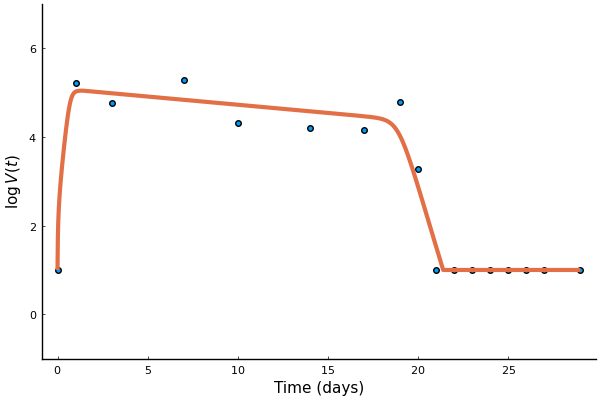

In [35]:
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.minimizer...)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
println("RSS = ", fit1.minimum)
[println(p, " = ", v) for (p, v) in zip(par_names, fit1.minimizer)];
pt

## Confidence intervals

Construct confidence intervals using MCMC and three approaches:

 a) Sample from the posterior distribution given individual data using a probabilistic model for each parameter and time dependent variance.
 
 b) Sample from the posterior distribution given individual data using a probabilistic model for each parameter and time-constant variance.

 c) Sample from the predictive posterior distribution given individual data using a probabilistic model for each parameter and time-constant variance.
 
 d) Sample from the posterior distribution given aggregated data using a probabilistic model for each parameter and time-constant variance.

 ?) Sample from the posterios distributrion and model with the mixed-effect model (NL-MELSM). (TODO)

In [13]:
# k = 1
# ttdata = tdata
# vvdata = data[k, :]
# tend = ttdata[end]
# cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)
# fit = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^5))

In [14]:
sampler = PG(10); nsamples = 1000; nchains = 4;
# sampler = HMC(0.01, 5); nsamples = 2000; nchains = 4;
# sampler = NUTS(); nsamples = 2000; nchains = 4;

###  a) Sample from the posterior distribution given individual data using a probabilistic model for each parameter and time dependent variance.

 - Variability per time
 
 - Prior distributions assume equal variability
 
 - Estimation per individual using population best estimate for the prior

$$
s \sim Exp(1) \\
a_1 \sim N(\hat a_1, s, 0, \infty) \\
a_2 \sim N(\hat a_2, s, a_1, \infty) \\
b_1 \sim N(\hat b_1, s, a_2, \infty) \\
b_2 \sim N(\hat b_2, s, b_1, \infty) \\
\alpha \sim N(\hat \alpha, s, 0, \infty) \\
\log V_{max} \sim N(\log \hat V_{max}, s, 0, \infty) \\
\sigma \sim N(\vec{0}, sI) \\
V(t_i) = N(\log V (t_i; \theta), \sigma_i )
$$

where 

$$
\theta = (a_1, a_2, b_1, b_2, \alpha, \log V_{max})
$$

However, this is not correct since it models separate errors for each observation.

In [15]:
@model function VLFmodel(t, v, p₀)
    # For each time point t[i], v[i] is a vector of observations
    # For now t and v have the same size, i.e. one obseravtion por time point
    tmax = maximum(t)
    # Prior distributions
    s ~ Exponential(1.0)
    a₁ ~ truncated(Normal(p₀[1], s), 0, p₀[3])
    a₂ ~ truncated(Normal(p₀[2], s), a₁, p₀[4])
    b₁ ~ truncated(Normal(p₀[3], s), a₂, tmax)
    b₂ ~ truncated(Normal(p₀[4], s), b₁, tmax)
    α ~ truncated(Normal(p₀[5], s), 0, Inf)
    logVmax ~ truncated(Normal(p₀[6], s), 0, Inf)
    σ ~ filldist(truncated(Normal(), 0, Inf), size(t, 1))
    # Model
    threshold = 0
    for i ∈ eachindex(v)
        v[i] ~ truncated(Normal(LogVirusLoad(t[i], a₁, a₂, b₁, b₂, α, logVmax), σ[i]), threshold, Inf)
    end
    return v
end

VLFmodel (generic function with 1 method)

In [16]:
chains_prior = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit1.minimizer), 
                         Prior(), nsamples), chainscat, 1:nchains)
chains = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit1.minimizer), 
                   sampler, nsamples), chainscat, 1:nchains)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Chains MCMC chain (1000×26×4 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = a₁, a₂, b₁, b₂, logVmax, s, α, σ[1], σ[2], σ[3], σ[4], σ[5], σ[6], σ[7], σ[8], σ[9], σ[10], σ[11], σ[12], σ[13], σ[14], σ[15], σ[16], σ[17]
internals         = logevidence, lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

          a₁    0.2486    0.4371     0.0069    0.0066   3377.0261    0.9999
          a₂    1.6045    0.7343     0.0116    0.0113   3677.9929    1.0000
          b₁   17.0032    0.6024     0.0095    0.0122   4092.1293    0.9998
          b₂   20.8868    0.5801     0.0092    0.0087   3937.0827    0.9996
     logVmax    5.1357    0.5023     0.0079    0.0076   3917.5327    1.0004
           s    0.3886    0.5150     0.0081    0.0087   4015.6741    1.0002
           α    0.

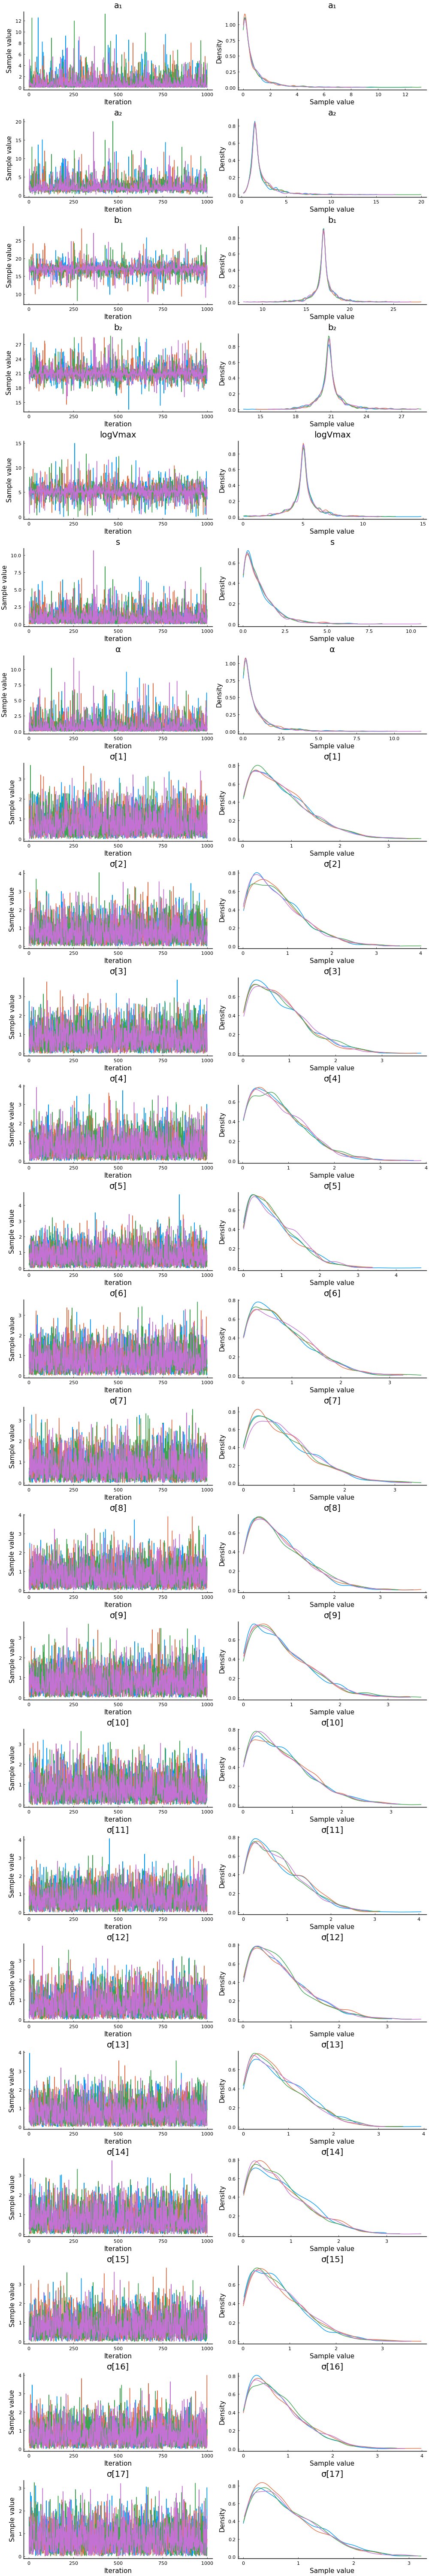

In [17]:
plot(chains_prior)

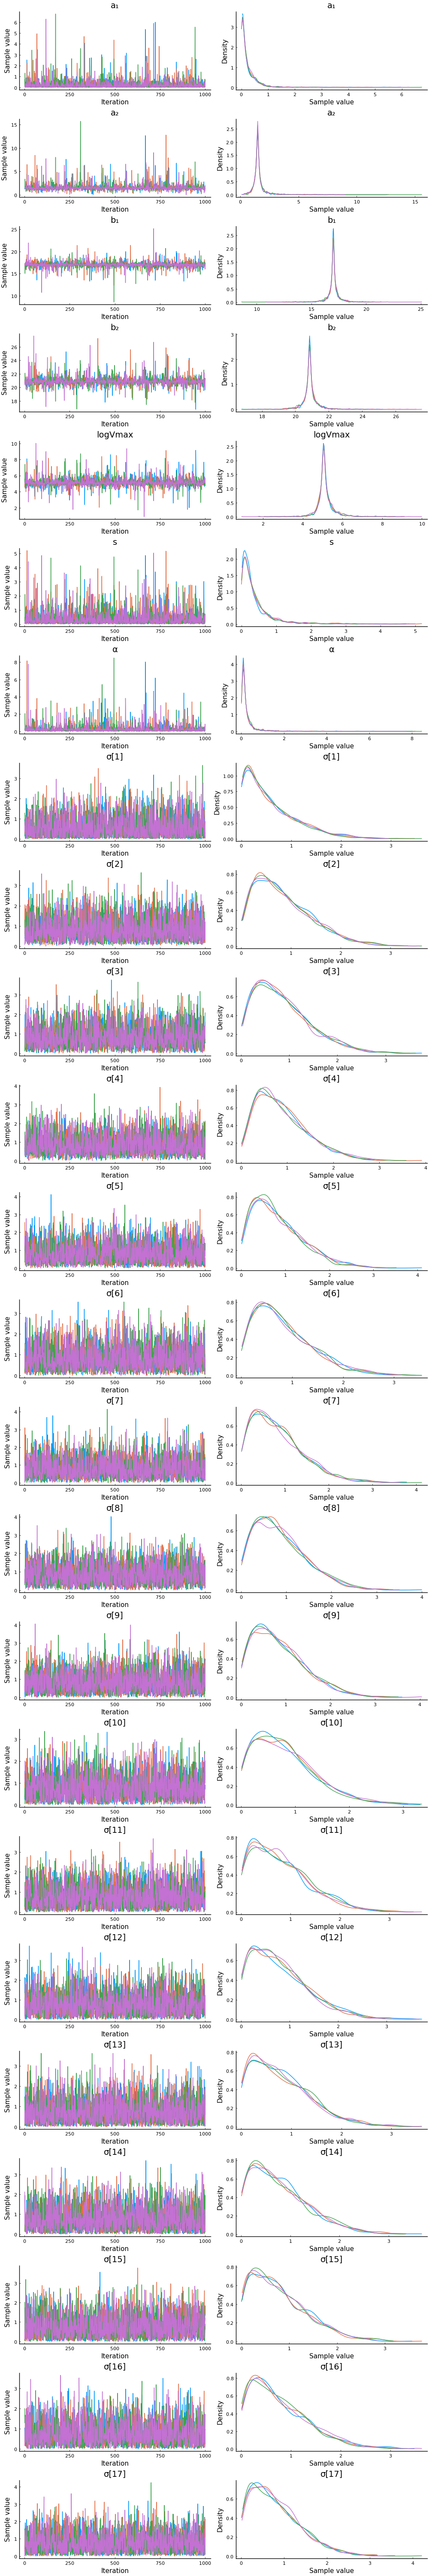

In [18]:
plot(chains)

Good convergence

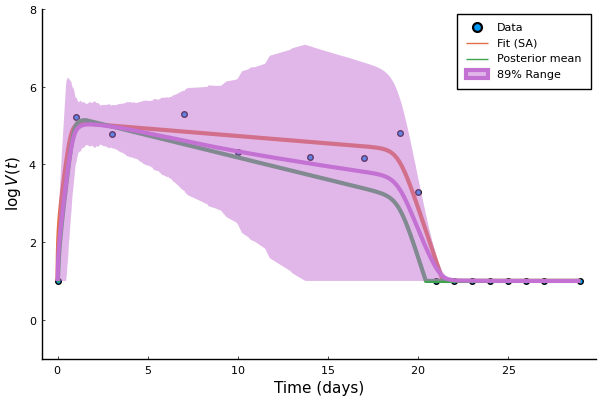

In [19]:
df = DataFrame(chains[:,:,1])[!, Symbol.(par_names)]
plot(ttdata, vvdata, seriestype=:scatter, label="Data")
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.minimizer...)
plot!(tt, vv, lw=3, label="Fit (SA)")
p = mean.(eachcol(df))
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=3, label="Posterior mean")
arr = [filter(!isnan, LogVirusLoad.(t, eachcol(df)...)) for t in tt]
m = [mean(v) for v in arr]
quantiles = [quantile(v, [0.055, 0.945]) for v in arr]
lower = [q[1] - m for (q, m) in zip(quantiles, m)]
upper = [q[2] - m for (q, m) in zip(quantiles, m)]
plot!(tt, m, lw=3, ribbon = [lower, upper], label=("89% Range"))
plot!(grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 8)))

Errors seem a little high.

### b) Sample from the posterior distribution given individual data using a probabilistic model for each parameter and time-constant variance.

To compute predictive posterior values we need to use common variance

In [20]:
@model function VLFmodel(t, v, p₀)
    tmax = maximum(t)
    # Prior distributions
    s ~ Exponential(1.0)
    a₁ ~ truncated(Normal(p₀[1], s), 0, p₀[3])
    a₂ ~ truncated(Normal(p₀[2], s), a₁, p₀[4])
    b₁ ~ truncated(Normal(p₀[3], s), a₂, tmax)
    b₂ ~ truncated(Normal(p₀[4], s), b₁, tmax)
    α ~ truncated(Normal(p₀[5], s), 0, Inf)
    logVmax ~ truncated(Normal(p₀[6], s), 0, Inf)
    σ ~ truncated(Normal(), 0, Inf)
    # Model
    threshold = 0
    for i ∈ eachindex(v)
        v[i] ~ truncated(Normal(LogVirusLoad(t[i], a₁, a₂, b₁, b₂, α, logVmax), σ), threshold, Inf)
    end
    return v
end

chains = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit1.minimizer), 
                   sampler, nsamples), chainscat, 1:nchains)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Chains MCMC chain (1000×10×4 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = a₁, a₂, b₁, b₂, logVmax, s, α, σ
internals         = logevidence, lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

          a₁    0.2652    0.5424     0.0086    0.0072   4144.1508    0.9993
          a₂    1.6257    0.8209     0.0130    0.0127   3958.6761    1.0005
          b₁   17.0193    0.7005     0.0111    0.0116   4016.0040    1.0002
          b₂   20.8889    0.6333     0.0100    0.0093   3946.0272    1.0002
     logVmax    5.1280    0.6128     0.0097    0.0099   4022.4774    1.0006
           s    0.4073    0.5898     0.0093    0.0093   4151.1281    1.0004
           α    0.3099    0.6379     0.0101    0.0110   4118.6038    0.9999
           σ    0.6505    0.4571     0.0072    0.

Sample for the posterior and predict, however, this does not include uncertainty from the data.

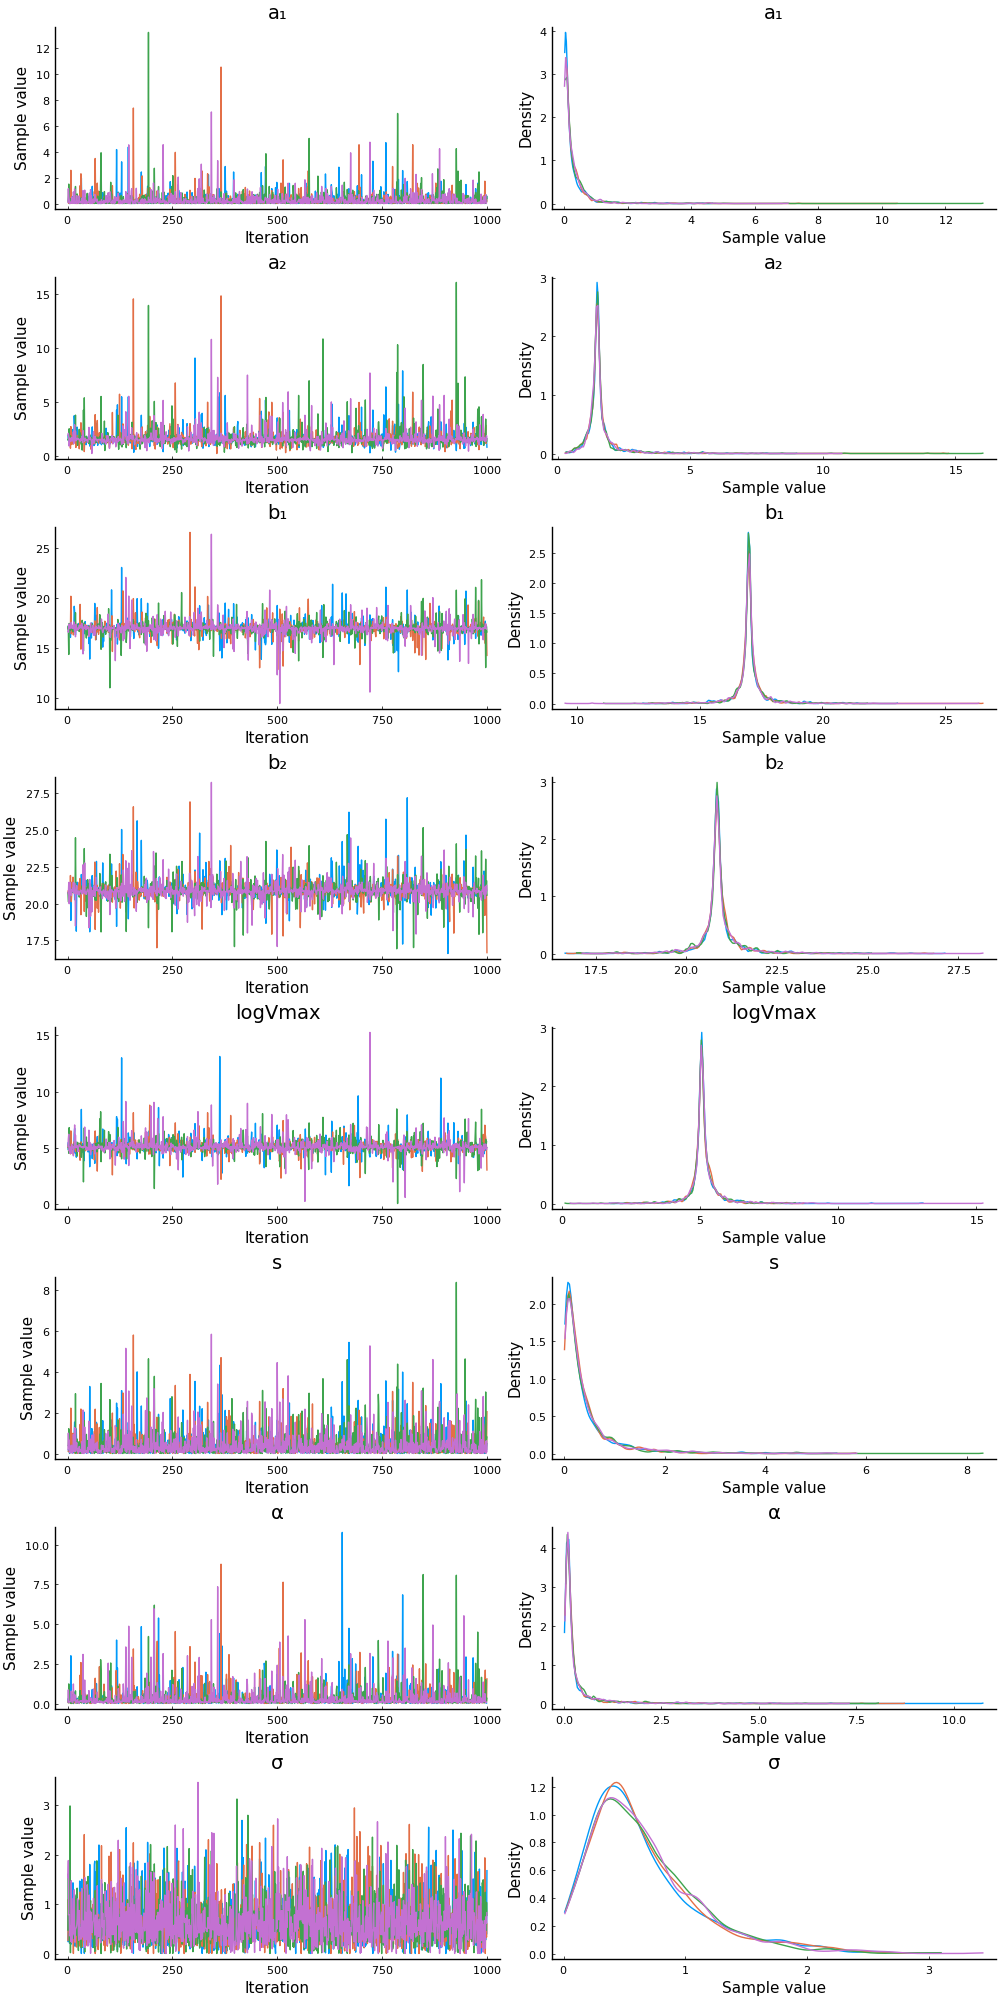

In [21]:
plot(chains)

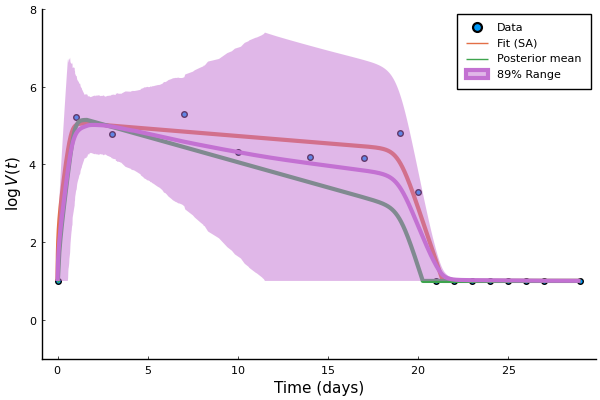

In [22]:
df = DataFrame(chains[:,:,1])[!, Symbol.(par_names)]
plot(ttdata, vvdata, seriestype=:scatter, label="Data")
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.minimizer...)
plot!(tt, vv, lw=3, label="Fit (SA)")
p = mean.(eachcol(df))
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=3, label="Posterior mean")
arr = [filter(!isnan, LogVirusLoad.(t, eachcol(df)...)) for t in tt]
m = [mean(v) for v in arr]
quantiles = [quantile(v, [0.055, 0.945]) for v in arr]
lower = [q[1] - m for (q, m) in zip(quantiles, m)]
upper = [q[2] - m for (q, m) in zip(quantiles, m)]
plot!(tt, m, lw=3, ribbon = [lower, upper], label=("89% Range"))
plot!(grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 8)))

## All mice

In [27]:
k = 10
ttdata = repeat(tdata, inner=k)
vvdata = reshape(data[:, 1:k], 1, :)[:]
tend = ttdata[end]
idx = .!ismissing.(vvdata)
ttdata = ttdata[idx]
vvdata = vvdata[idx]
cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)

cost (generic function with 1 method)

In [28]:
fit1 = fitVLF()

SAMIN results
NO CONVERGENCE: MAXEVALS exceeded

     Obj. value:       10736.89496

       parameter      search width
         9.03595           0.00043 
         9.04939           0.00000 
        21.67712           0.00000 
        28.99999           0.00001 
        10.00000           0.00000 
        25.00000           0.00000 
SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
25 out of  150 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 59251

     Obj. value:  16200.1243113300

       parameter      search width
        12.56419           0.00000 
        12.78241           0.00000 
        21.83178           0.00000 
        29.00000           0.00000 
        10.00000           0.00000 
        25.00000           0.00000 

SAMIN results
NO CONVERGENCE: MAXEVALS exceeded

     Obj. value:       1

 * Status: failure

 * Candidate solution
    Final objective value:     4.612073e+03

 * Found with
    Algorithm:     SAMIN

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   39  (vs limit Inf)
    Iterations:    53851
    f(x) calls:    53851
    ∇f(x) calls:   0


In [30]:
@model function VLFmodel(t, v, p₀)
    tmax = maximum(t)
    # Prior distributions
    s ~ Exponential(1.0)
    a₁ ~ truncated(Normal(p₀[1], s), 0, p₀[3])
    a₂ ~ truncated(Normal(p₀[2], s), a₁, p₀[4])
    b₁ ~ truncated(Normal(p₀[3], s), a₂, tmax)
    b₂ ~ truncated(Normal(p₀[4], s), b₁, tmax)
    α ~ truncated(Normal(p₀[5], s), 0, Inf)
    logVmax ~ truncated(Normal(p₀[6], s), 0, Inf)
    σ ~ truncated(Normal(), 0, Inf)
    # Model
    for i ∈ eachindex(v)
        v[i] ~ Normal(LogVirusLoad(t[i], a₁, a₂, b₁, b₂, α, logVmax), σ)
    end
    return v
end

chains = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit1.minimizer), 
                   sampler, nsamples), chainscat, 1:nchains)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:32
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:31
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:31
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:31


Chains MCMC chain (1000×10×4 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = a₁, a₂, b₁, b₂, logVmax, s, α, σ
internals         = logevidence, lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

          a₁    1.3010    1.0207     0.0161    0.0209   3737.3264    0.9998
          a₂    2.0623    1.5583     0.0246    0.0277   3744.1660    0.9993
          b₁   12.5917    1.3003     0.0206    0.0193   4047.3712    1.0003
          b₂   28.2709    1.0616     0.0168    0.0175   3804.6314    1.0001
     logVmax   24.9277    1.2943     0.0205    0.0234   4274.1882    0.9999
           s    0.9220    0.9416     0.0149    0.0167   3985.4003    0.9997
           α    9.9996    1.3121     0.0207    0.0195   4157.5481    1.0002
           σ    1.2595    0.6943     0.0110    0.

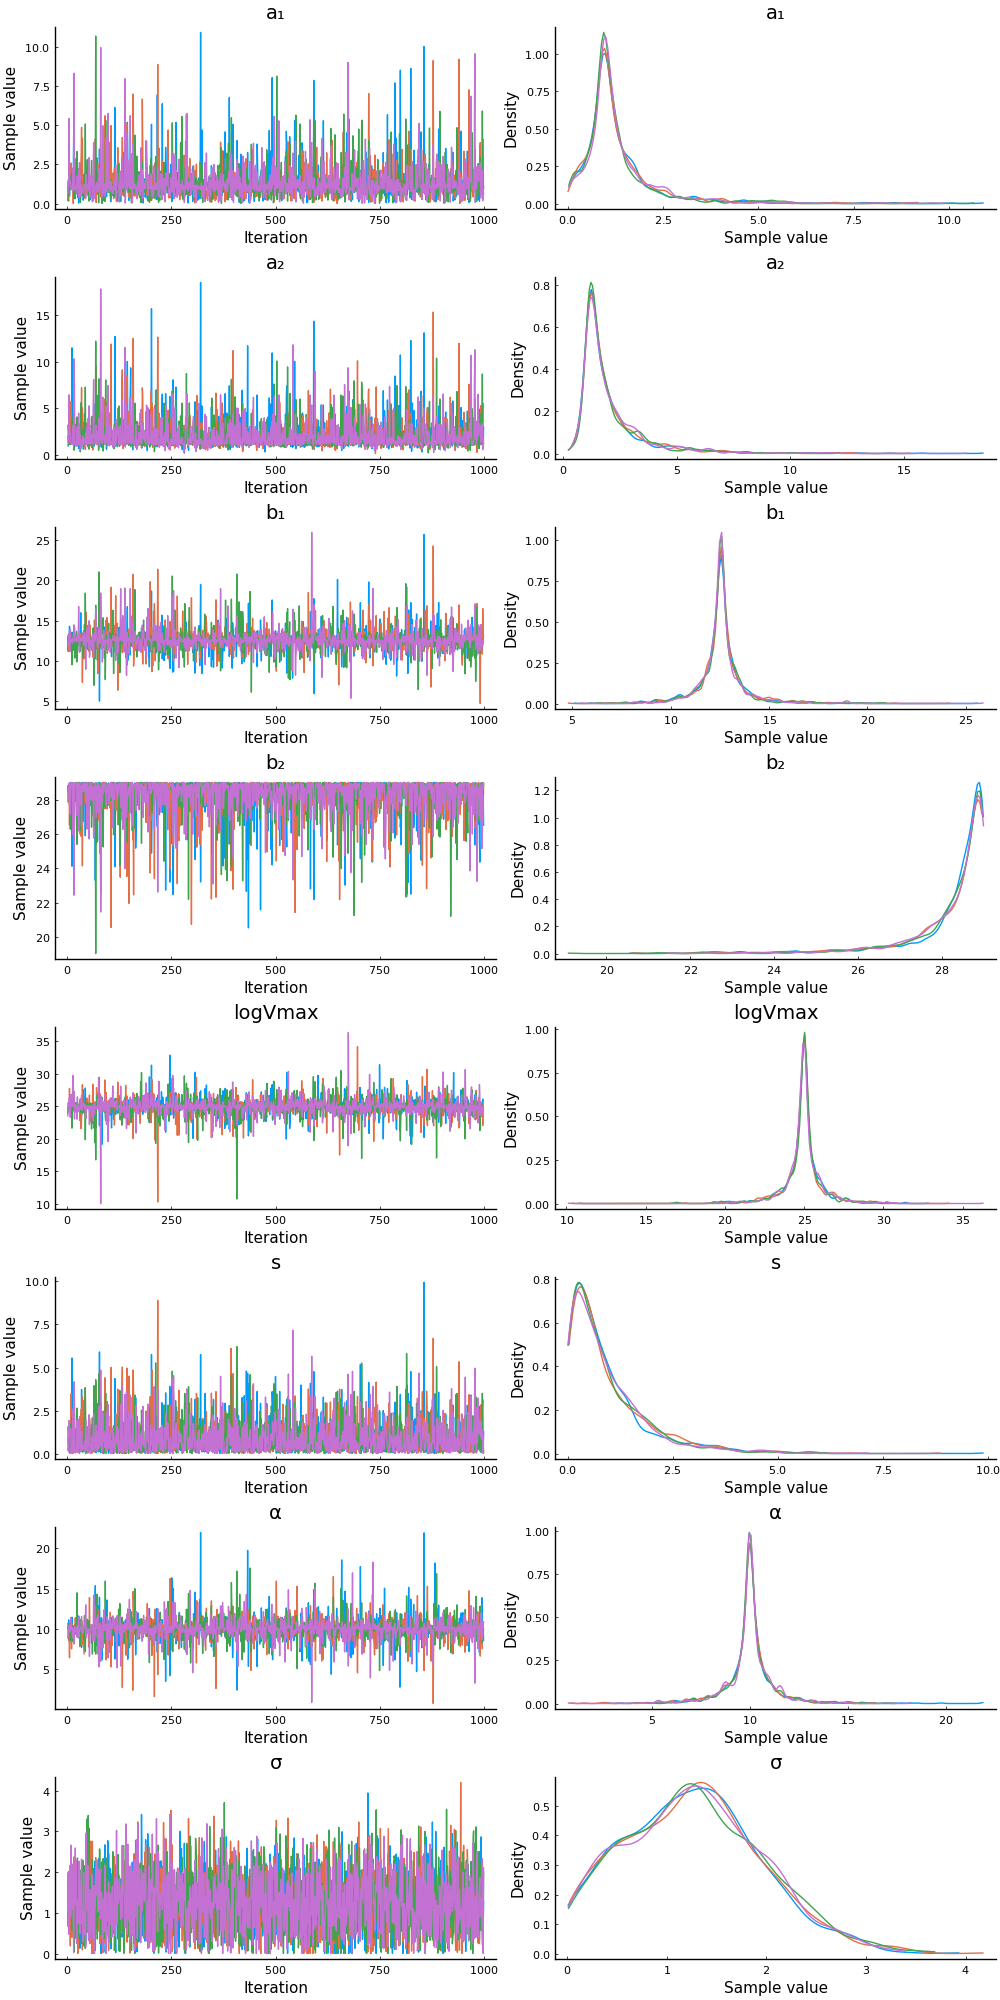

In [31]:
plot(chains)

In [30]:
df = DataFrame(chains[:,:,1])[!, Symbol.(par_names)]
# plot(ttdata, vvdata, seriestype=:scatter)
# tt = [range(0., tend, step=1e-2);]
m = mean.(eachcol(df))
l = quantile.(eachcol(df), 0.05)
u = quantile.(eachcol(df), 0.95)
[println(par_names[i], " = ", m[i], ", CI=[", l[i], ",", u[i], "]") for i in eachindex(m)];

a₁ = 0.8577755473831176, CI=[0.23960474340664167,1.743089745551916]
a₂ = 3.2759811735196718, CI=[2.336523124176211,4.5501927946758425]
b₁ = 6.491625450707352, CI=[5.490419692912621,7.837864091003773]
b₂ = 7.945141685642804, CI=[7.072472331195737,9.531159171539393]
α = 0.7610349617786686, CI=[0.14568757446440703,1.9834099247684946]
logVmax = 6.131625614575609, CI=[5.254327729647955,7.3085438935661795]


6-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

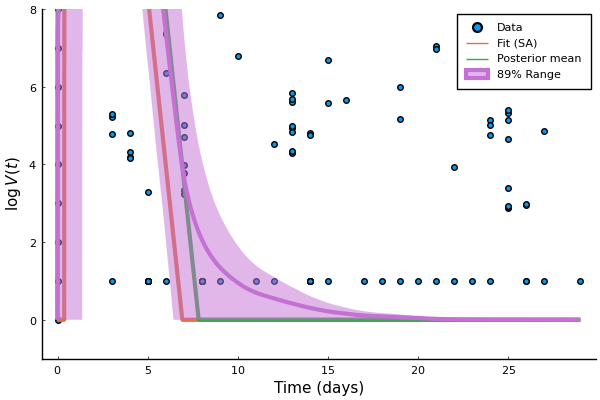

In [32]:
df = DataFrame(chains[:,:,1])[!, Symbol.(par_names)]
plot(ttdata, vvdata, seriestype=:scatter, label="Data")
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad.(tt, fit1.minimizer...)
plot!(tt, vv, lw=3, label="Fit (SA)")
p = mean.(eachcol(df))
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=3, label="Posterior mean")
arr = [filter(!isnan, LogVirusLoad.(t, eachcol(df)...)) for t in tt]
m = [mean(v) for v in arr]
quantiles = [quantile(v, [0.055, 0.945]) for v in arr]
lower = [q[1] - m for (q, m) in zip(quantiles, m)]
upper = [q[2] - m for (q, m) in zip(quantiles, m)]
plot!(tt, m, lw=3, ribbon = [lower, upper], label=("89% Range"))
plot!(grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 8)))

## Compute a set of best parameters

$$
\hat \Theta = \{\theta \in \mathbb{R}^k \,|\, \text{RSS}(\theta) = \sum_i \|f(t_i, \theta) - y_i\|^2 < \epsilon \}.
$$

In [55]:
k = 2
ttdata = repeat(tdata, inner=1)
tend = ttdata[end]
vvdata = reshape(data[:, k], 1, :)[:]
idx = .!ismissing.(vvdata)
ttdata = ttdata[idx]
vvdata = vvdata[idx]
cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)

cost (generic function with 1 method)

In [33]:
# @model function prior(tmax, lVmax)
#     a₁ ~ Uniform(0, 2.5)
#     a₂ ~ Uniform(a₁, tmax)
#     b₁ ~ Uniform(a₂, tmax)
#     b₂ ~ Uniform(b₁, tmax)
#     α ~ truncated(Normal(0, 2), 0, Inf)
#     logVmax ~ truncated(Normal(lVmax, 1), 0, Inf)
# end
# prior_sample = sample(prior(tdata[end], mean(maximum.(eachrow(data)))), 
#                          Prior(), 100)
# density(prior_sample[:a₁])
# density!(prior_sample[:a₂])
# density!(prior_sample[:b₁])
# density!(prior_sample[:bddd₂])
# plot!(xlim=(0, tdata[end]))

In [63]:
function my_prior_rand(p)
    tmax = tdata[end]
    s = .1
    a₁ = rand(truncated(Normal(p[1], s), 0, tmax))
    a₂ = rand(truncated(Normal(p[2], s), a₁, tmax))
    b₁ = rand(truncated(Normal(p[3], s), a₂, tmax))
    b₂ = rand(truncated(Normal(p[4], s), b₁, tmax))
    α = rand(truncated(Normal(p[5], s), 0, Inf))
    logVmax = rand(truncated(Normal(p[6], s), 0, Inf))
    return [a₁, a₂, b₁, b₂, α, logVmax]
end

my_prior_rand (generic function with 1 method)

In [57]:
fit1 = fitVLF()

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
27 out of  150 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 49051

     Obj. value:      5.0871420207

       parameter      search width
         0.00000           0.00000 
         8.28851           0.00000 
        18.25163           0.00000 
        20.91849           0.00000 
         0.32236           0.00000 
         5.64452           0.00000 

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
15 out of  150 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 54901

     Obj. value:      1.5605446640

       parameter      search width
         0.00000           0.00000 

 * Status: failure

 * Candidate solution
    Final objective value:     1.560545e+00

 * Found with
    Algorithm:     SAMIN

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    54901
    f(x) calls:    54901
    ∇f(x) calls:   0


In [64]:
par_array = []
RSS_array = []
maxiter = 10^4
# println("RSS: ", fit1.minimum)
tol = 1e0
for k = 1:maxiter
#     println("\nIter: ", k)
    par = my_prior_rand(fit1.minimizer)
    rss = cost(par)
#     if (rss - fit.minimum)/fit.minimum < tol
#         println("passed")
        push!(par_array, par)
        push!(RSS_array, cost(par))
#     end
end
# length(par_array)

In [65]:
tol = 1e-1
RSS_best = minimum(RSS_array)
idx = (RSS_array .- RSS_best)/RSS_best .< tol
par_best = par_array[idx]
print(sum(idx), " best estimates found within ", RSS_best, " + ", tol)
# par_best = par_array
RSS_array[idx];

40 best estimates found within 1.3932325355944297 + 0.1

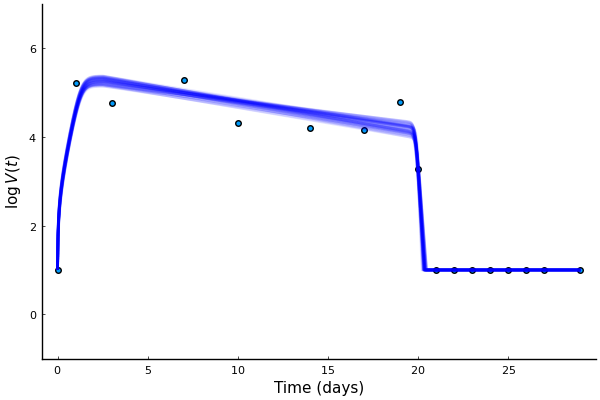

In [66]:
plot(ttdata, vvdata, seriestype=:scatter)
tt = [range(0., tend, step=1e-2);]
for par ∈ par_best
    vv = LogVirusLoad.(tt, par...)
#     println(par)
    plot!(tt, vv, line=(2, :blue, 0.1))
end
plot!(tt, vv, line=(2, :blue, 0.1))
plot!(legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

## Estimation of errors

Construct estimation errors around each data point using MCMC.

This is only the error at the time centered at the average virus load curve.

Cons:

 - No variability per individual
 
 - No variability per parameter estimate

Get a first estimate using optimization for the prior distributions

In [9]:
sampler = PG(10); nsamples = 1000; nchains = 4;
# sampler = HMC(0.01, 5); nsamples = 2000; nchains = 4;
# sampler = NUTS(); nsamples = 2000; nchains = 4;

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


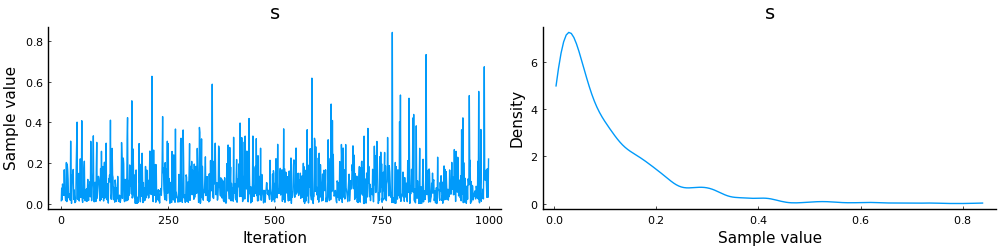

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


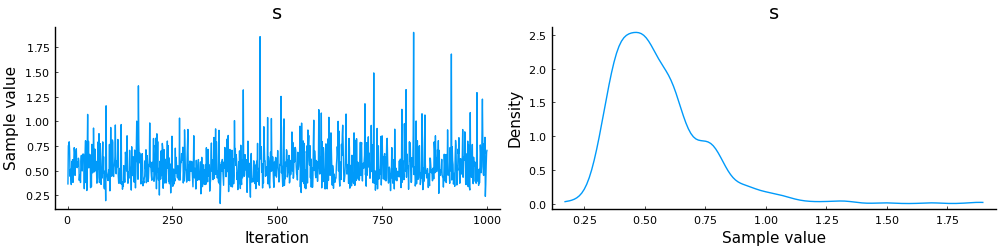

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


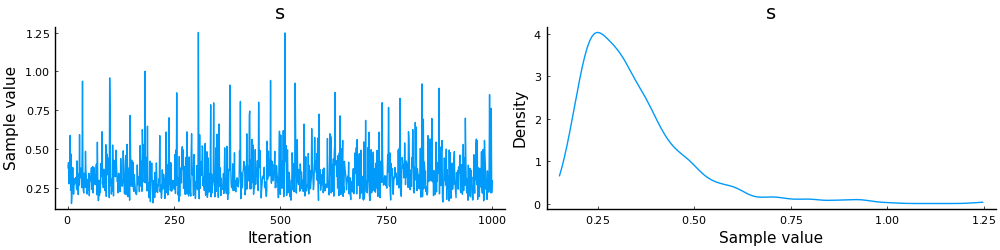

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


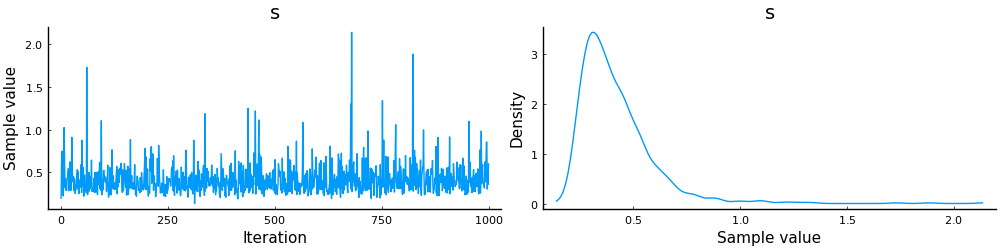

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


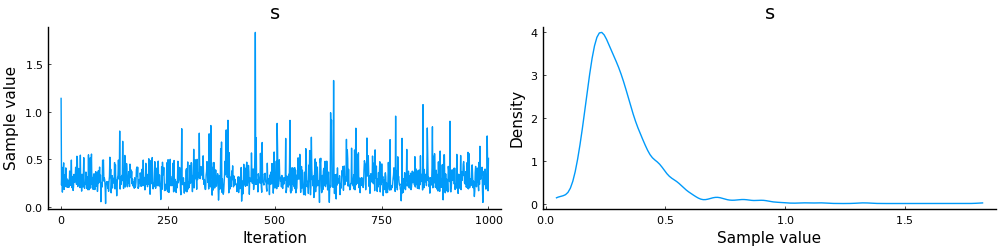

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


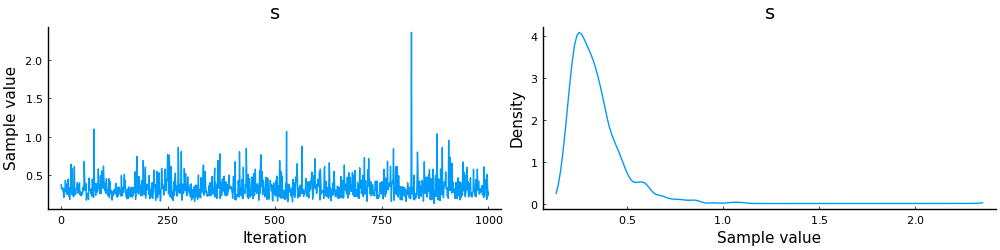

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


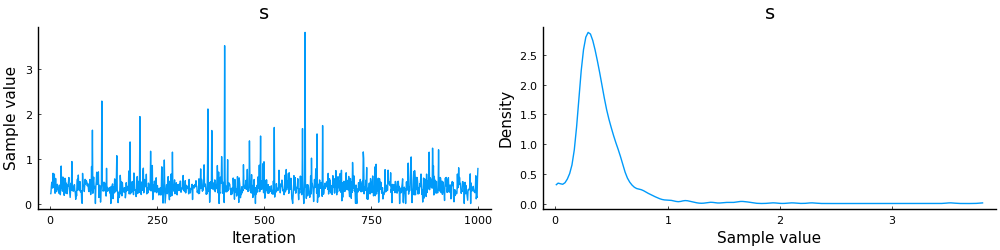

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


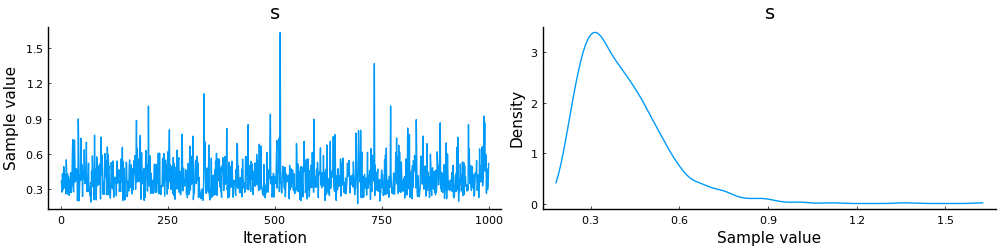

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


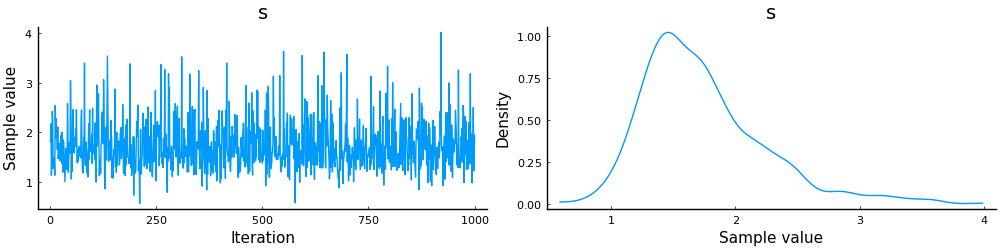

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


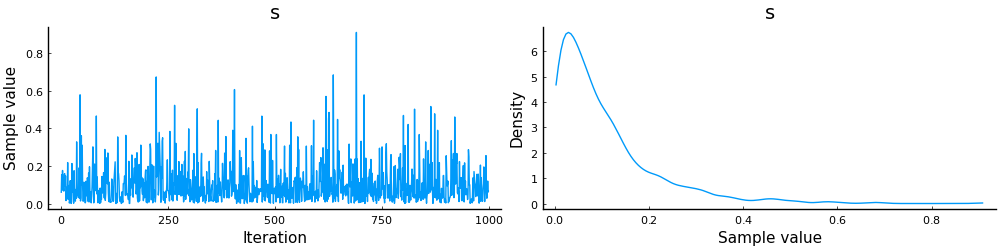

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


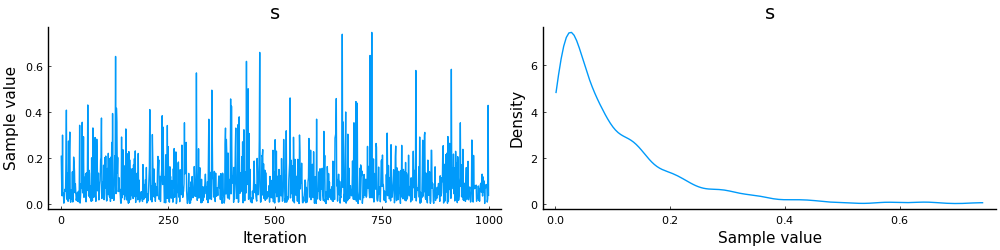

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


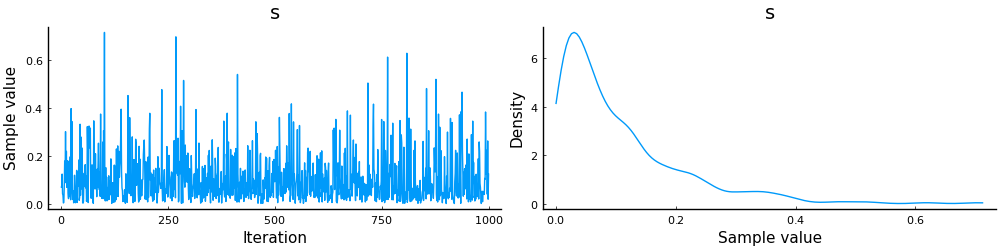

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


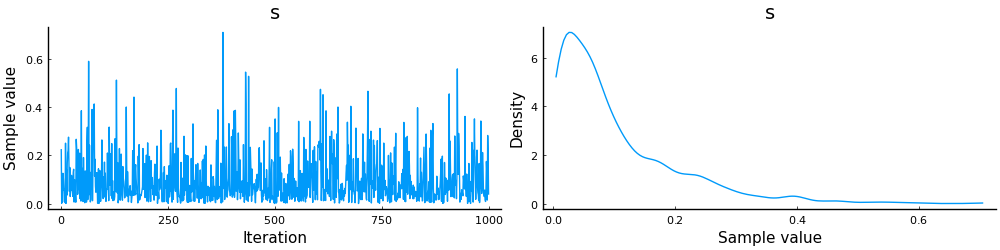

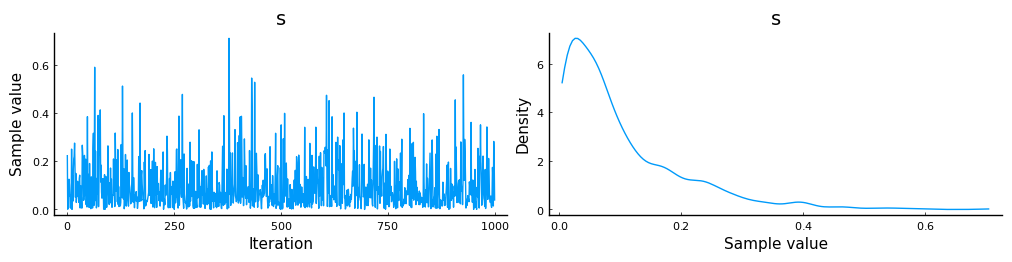

In [10]:
@model function errors_model(t, v, p)
    # one-time data with multiple observations
    s ~ Exponential(1.0)
    
    for i in eachindex(v)
        v[i] ~ Normal(LogVirusLoad(t, p...), s)
    end
end
err = zero(tdata)
# estimate errors for each time data point
for i in eachindex(tdata)
    chain = sample(errors_model(tdata[i], data[:, i], fit.minimizer), sampler, nsamples)
    err[i] = mean(chain[:s])
    display(plot(chain))
end

Plot error bars using 95% confidence interval

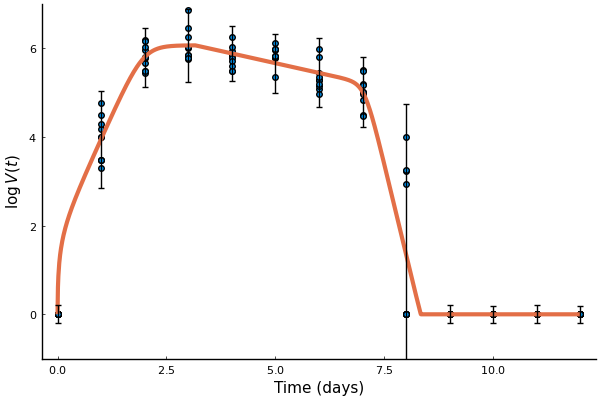

In [11]:
plot(ttdata, vvdata, seriestype=:scatter)
tt = [range(0., tend, step=1e-2);]
p = Optim.minimizer(fit)
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=3)
tt = tdata
vv = LogVirusLoad.(tt, fit.minimizer...)
plot!(tt, vv, lw=0, yerr=1.96err)
plot!(legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

Now for only one individual (mice)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


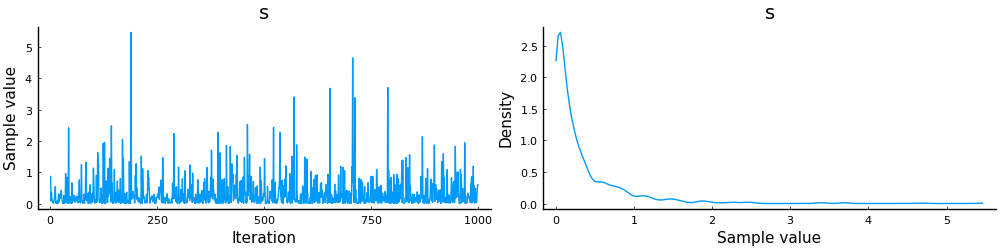

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


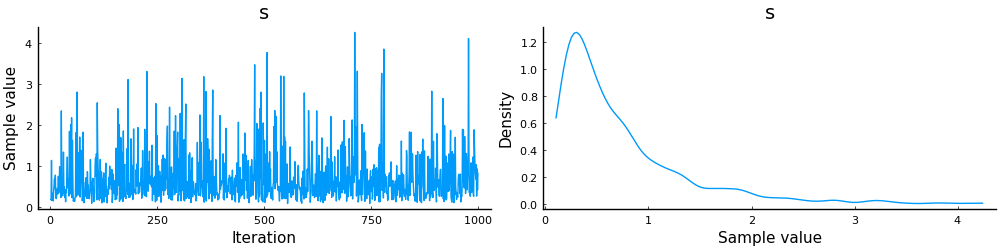

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


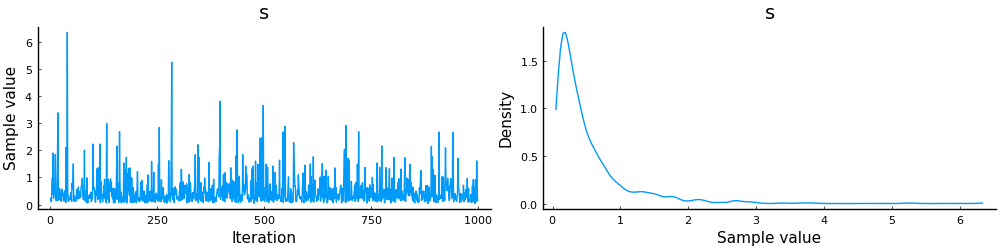

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


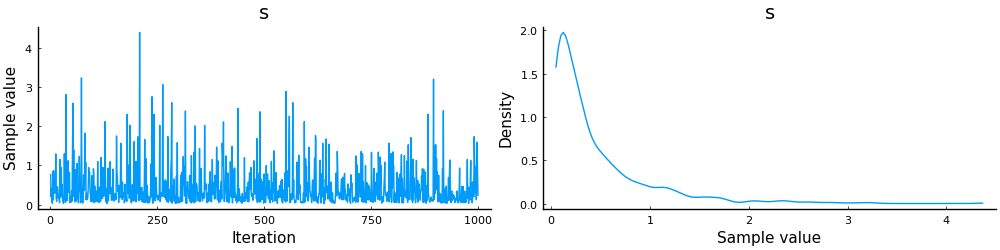

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


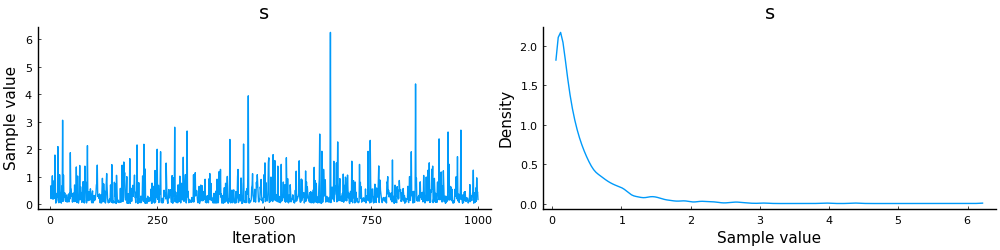

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


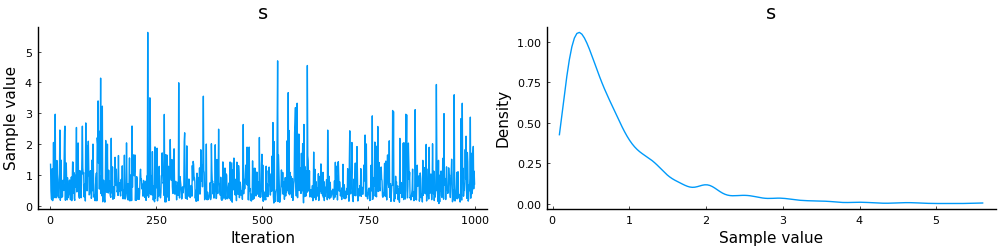

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


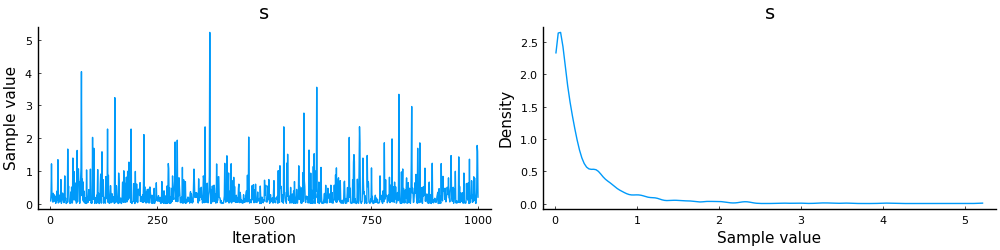

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


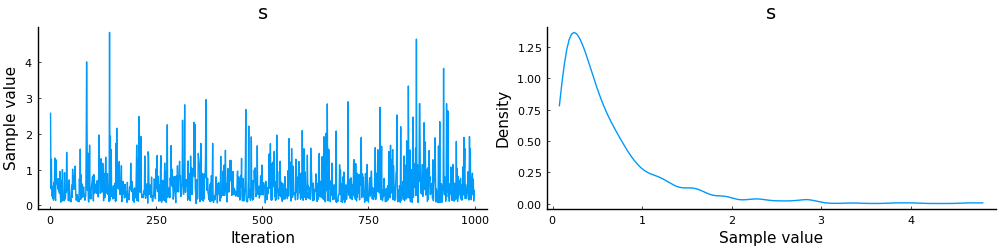

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


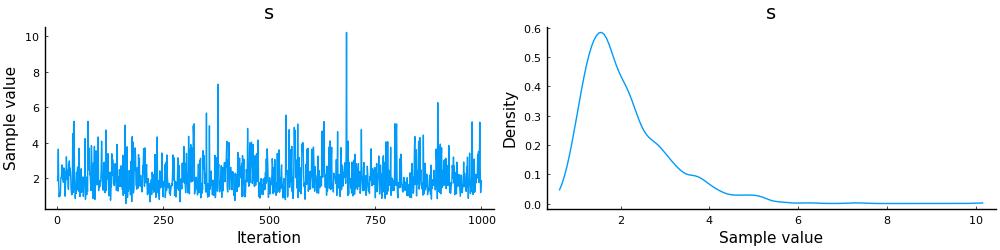

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


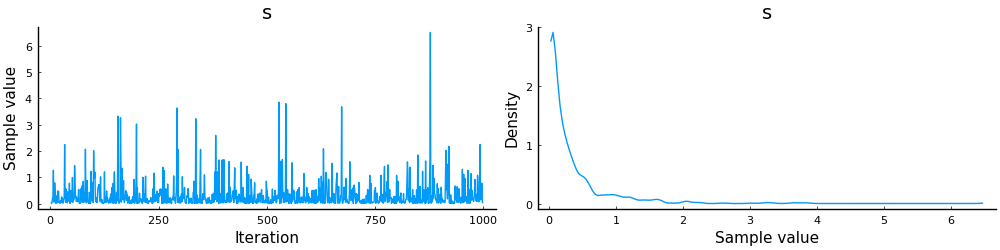

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


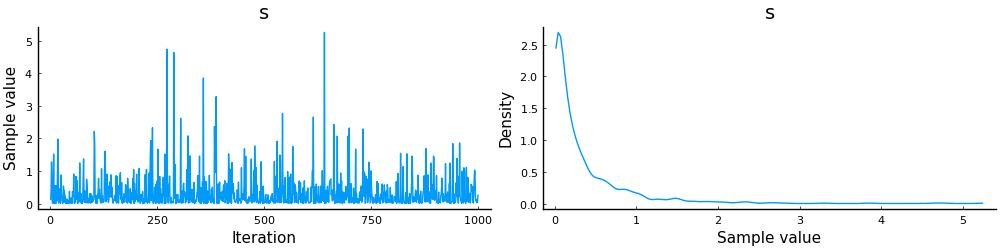

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


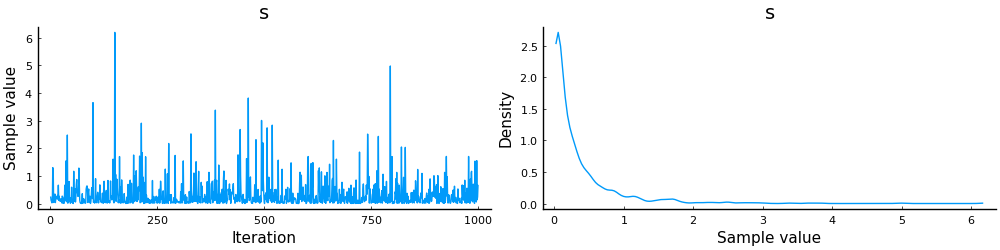

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


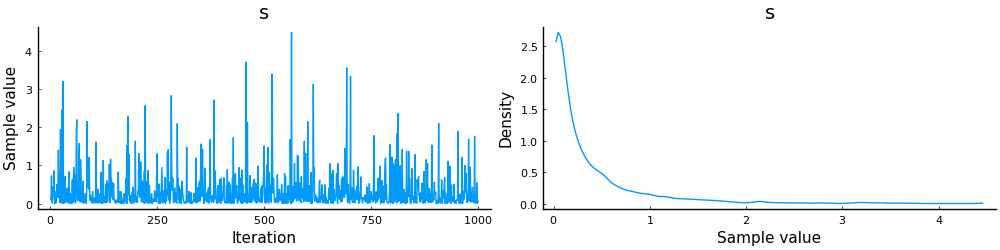

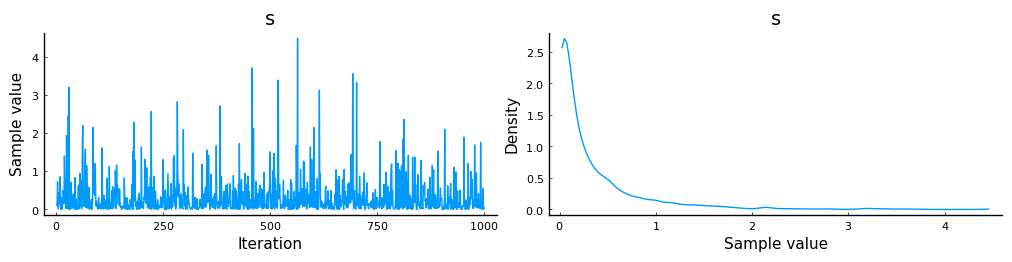

In [12]:
k = 1 # data_no. Mice number k
@model function errors_model(t, v)
    
    s ~ Exponential(1.0)
    
    for i in eachindex(v)
        v[i] ~ Normal(LogVirusLoad(t, fit.minimizer...), s)
    end
end
err = zero(tdata)
for i in eachindex(tdata)
    chain = sample(errors_model(tdata[i], data[k, i]), sampler, nsamples)
    err[i] = mean(chain[:s])
    display(plot(chain))
end

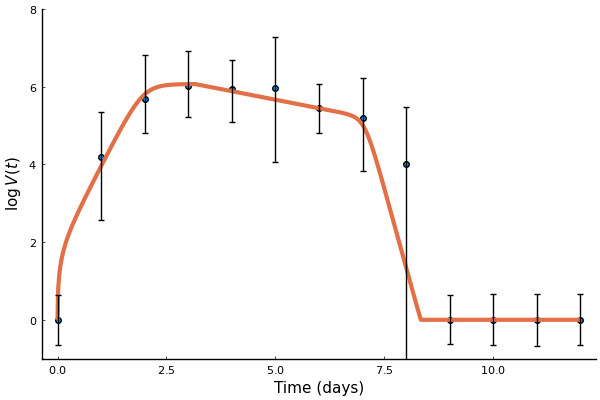

In [13]:
plot(tdata, data[k, :], seriestype=:scatter)
tt = [range(0., tend, step=1e-2);]
p = Optim.minimizer(fit)
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=3)
tt = tdata
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=0, yerr=1.96err)
plot!(legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 8)))